In [23]:
# Import math functions (numpy) and sympy for creating formulars
from IPython.display import clear_output
import numpy as np
import sympy as sp
from fractions import Fraction
import matplotlib.pyplot as plt

In [24]:
# Import qiskit framework
from qiskit import IBMQ
from qiskit_optimization import QuadraticProgram
from qiskit import Aer
from qiskit.utils import QuantumInstance
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit.algorithms import QAOA

In [25]:
#IBMQ.load_account()
#provider = IBMQ.get_provider(hub='ibm-q')

In [26]:
clear_output()

## Define Functions

In [27]:
def construct_function(kl, kh, n, h):
    """Constructs the mathematical function to be optimized

    Args:
        kl (double): low k
        kh (double): high k
        n (int): number of heads
        h (list): values for each of the heads

    Returns:
        sympyfunction, dict: mathematical sympy function with coefficients
    """
    function = 0
    sp.init_printing(use_unicode=True)
    
    # construct variables for each permeability
    for i in range(1,n):
        globals()['q%s' % i] = sp.symbols('q'+str(i))
        globals()['h%s' % i] = sp.symbols('q'+str(i))
        
    # for each permeability, add its contribution to the total cost function
    for i in range(2,n):
        term = ((kl+globals()['q%s' % (i-1)]*(kh-kl))*(h[i-2]-h[i-1])+(kl+globals()['q%s' % (i)]*(kh-kl))*(h[i]-h[i-1]))**2
        function = function + term
        
    # expand and simplify the cost function
    function = sp.expand(function)
    
    # convert all square terms into linear terms as qi^2 = qi = 0 or 1 for all i and simplify the cost function
    for i in range(1,n):
        function = function.subs(sp.symbols('q'+str(i))**2, (sp.symbols('q'+str(i))))
        coeffs = sp.Poly(function).as_dict()
        
    # function in sympy form and coefficients of all terms in an easily readble dictionary form returned
    return function, coeffs

In [28]:
def generate_QP(coeffs, n, verbose=False):
    """Generates the Quadratic Program to be optimized

    Args:
        coeffs (dict): Contains the coefficients from the sympy funciton
        n (int): Number of heads

    Returns:
        QuadraticProgram: The quadratic program to optimize
    """
    qp = QuadraticProgram()
    for i in range(1,n):
        qp.binary_var('q'+str(i))
    constant = 0
    linear = {}
    quadratic = {}
    for key,value in coeffs.items():
        if sum(key) == 0:
            constant = float(value)
        elif sum(key) == 1:
            term = 'q'+str(np.argmax(key)+1)
            linear[term] = float(value)
        else:
            indices = [i[0] for i in np.argwhere(np.array(key)>0)]
            term = ('q'+str(indices[0]+1),'q'+str(indices[1]+1))
            quadratic[term] = float(value)
    qp.minimize(linear=linear, quadratic=quadratic, constant=constant)
    if verbose:
        print(qp.export_as_lp_string())
    return qp

In [29]:
def hydrologic_inverse_analysis(kl,kh,n,h, verbose=False):
    """Constructs and solves the mathematical function

    Args:
        kl (double): low k
        kh (double): high k
        n (int): number of heads
        h (list): values for each of the heads
        verbose (Bool): Output information or not

    Returns:
        list: list with the estimated k values for the heads
    """
    # Create the mathematical function
    function, coeffs = construct_function(kl,kh,n,h)
    print('Function in Sympy:', function)
    # Generate the quadratic problem and solve it with Qiskit
    qp = generate_QP(coeffs,n,verbose)
    qins = QuantumInstance(backend=Aer.get_backend('qasm_simulator'), shots=1000, seed_simulator=123)
    meo = MinimumEigenOptimizer(min_eigen_solver=QAOA(reps=1, quantum_instance=qins))
    result = meo.solve(qp)
    if verbose:
        print('\nrun time:', result.min_eigen_solver_result.optimizer_time)
        print(result)
    k = [int(i) for i in list(kl+result.x*(kh-kl))]
    if verbose:
        print('k_res: ', k)
    return k

In [30]:
def evaluate_performance(k_true,k_res, verbose=False):
    """Evaluate the performance of the estimation by calculating missmatches and comparing them to the total number of values

    Args:
        k_true (list): True k values
        k_res (list): Estimated k values
        verbose (Bool): Output information or not

    Returns:
        double: Error rate
    """
    total_number = len(k_true)
    false_count = 0
    for i in range(len(k_true)):
        if k_true[i] != k_res[i]:
            false_count += 1
    error_rate = false_count / total_number
    if verbose:
        print('Error Rate = '+ str(error_rate*100)+'%')
    return error_rate

## Small 1D Problem

Given: 3 heads with $h_1=1, h_2=\frac{1}{3}, h_3=0$ <br>
Assumption: $k_l = 1, k_h = 2$ <br>
Task: minimize  $f(q_1, q_2) = \frac{8}{9}q_1 − \frac{1}{9}q_2 − \frac{4}{9}q_1q_2 + \frac{1}{9}$

In [31]:
k_true = [1,2]

In [32]:
kl = 1
kh = 2
n = 3
h = [1,1/3,0]

In [33]:
k_res = hydrologic_inverse_analysis(kl,kh,n,h,verbose=True)

Function in Sympy: -0.444444444444444*q1*q2 + 0.888888888888889*q1 - 0.111111111111111*q2 + 0.111111111111111
\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: CPLEX

Minimize
 obj: 0.888888888889 q1 - 0.111111111111 q2 + [ - 0.888888888889 q1*q2 ]/2 +
      0.111111111111
Subject To

Bounds
 0 <= q1 <= 1
 0 <= q2 <= 1

Binaries
 q1 q2
End


run time: 0.018978357315063477
optimal function value: 2.7755575615628914e-17
optimal value: [0. 1.]
status: SUCCESS
k_res:  [1, 2]


In [34]:
error_rate = evaluate_performance(k_true, k_res, verbose=True)

Error Rate = 0.0%


## Larger 1D Problem

In [35]:
def generate_random_1D_data(kl, kh, n):
    """Generate random data for the value of the heads

    Args:
        kl (double): low k
        kh (double): high k
        n (int): number of heads

    Returns:
        list, list: Returns the random true k values and the linked head values
    """
    k_true = np.random.randint(2, size=n-1)*(kh-kl) +kl
    
    h1=np.random.rand()
    h2=np.random.rand()
    h=np.array([h1,h2])
    for i in range(1,n-1):
        h_next = h[i]+k_true[i-1]/k_true[i]*(h[i]-h[i-1])
        h=np.append(h, np.array([h_next]))
    return k_true, h

In [36]:
kl = 1
kh = 2
n = 15

In [37]:
# Generate a dataset with true ks and the head values
k_true, h = generate_random_1D_data(kl, kh, n)
print("k =", k_true)
print("h =", h)

k = [1 1 1 1 1 2 2 2 1 1 2 1 2 2]
h = [0.34335662 0.70374699 1.06413737 1.42452774 1.78491812 2.14530849
 2.32550368 2.50569887 2.68589406 3.04628443 3.40667481 3.58687
 3.94726037 4.12745556 4.30765075]


In [38]:
# Estimate the k values, given only the head values
k_res = hydrologic_inverse_analysis(kl,kh,n,h,verbose=True)

Function in Sympy: -0.259762445984014*q1*q2 + 0.129881222992007*q1 - 0.129881222992007*q10*q11 - 0.259762445984014*q10*q9 + 0.389643668976021*q10 - 0.129881222992007*q11*q12 - 0.0649406114960034*q11 - 0.129881222992007*q12*q13 + 0.519524891968028*q12 - 0.0649406114960034*q13*q14 + 0.0324703057480017*q14 - 0.259762445984014*q2*q3 + 0.259762445984014*q2 - 0.259762445984014*q3*q4 + 0.259762445984014*q3 - 0.259762445984014*q4*q5 + 0.259762445984014*q4 - 0.129881222992007*q5*q6 + 0.389643668976021*q5 - 0.0649406114960034*q6*q7 - 0.0649406114960034*q7*q8 + 0.0649406114960034*q7 - 0.129881222992007*q8*q9 + 0.389643668976021*q9 + 0.162351528740009
\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: CPLEX

Minimize
 obj: 0.129881222992 q1 + 0.259762445984 q2 + 0.259762445984 q3
      + 0.259762445984 q4 + 0.389643668976 q5 + 0.064940611496 q7
      + 0.389643668976 q9 + 0.389643668976 q10 - 0.064940611496 q11
      + 0.519524891968 q12 + 0.032470305748 q14 + [ - 0.519

In [39]:
# Compare the estimation
error_rate = evaluate_performance(k_true, k_res, verbose=True)

Error Rate = 14.285714285714285%


## 1D Problem Performance Analysis
Show how the number of heads influences the estimation error

0
3
Function in Sympy: -1.65228605327085*q1*q2 + 0.826143026635426*q1 + 0.826143026635426*q2
4
Function in Sympy: -7.2248140225634e-5*q1*q2 + 3.6124070112817e-5*q1 - 7.2248140225634e-5*q2*q3 + 7.2248140225634e-5*q2 + 3.6124070112817e-5*q3
5
Function in Sympy: -0.716612466894909*q1*q2 + 0.358306233447455*q1 - 0.358306233447455*q2*q3 + 1.07491870034236*q2 - 0.179153116723727*q3*q4 + 8.32667268468867e-17*q3 + 0.0895765583618637*q4 + 0.0895765583618636
6
Function in Sympy: -0.330541106532546*q1*q2 + 0.661082213065092*q1 - 0.165270553266273*q2*q3 - 0.165270553266273*q3*q4 + 0.165270553266273*q3 - 0.165270553266273*q4*q5 + 0.165270553266273*q4 + 0.0826352766331366*q5 + 0.0826352766331365
7
Function in Sympy: -0.0207455802267998*q1*q2 + 0.0414911604535996*q1 - 0.0103727901133999*q2*q3 + 1.73472347597681e-17*q2 - 0.0103727901133999*q3*q4 + 0.0103727901133999*q3 - 0.0207455802267998*q4*q5 - 0.0207455802267998*q5*q6 + 0.0829823209071993*q5 - 0.00518639505669996*q6 + 0.0155591851700999
8
Function

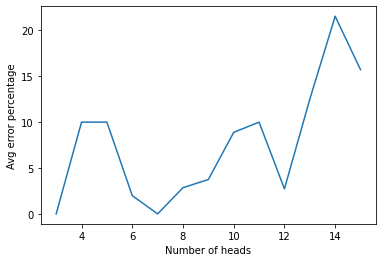

In [51]:
# Set everything up
runtime = 10
num_heads = 15
error_set = []
avg_set = []
# Start the runtime
for i in range(runtime):
    print(i)
    heads = []
    error_rates = []
    kl = 1
    kh = 2
    # Calculate the values for different amounts of heads
    for n in range(3,num_heads+1):
        print(n)
        k_true, h = generate_random_1D_data(kl, kh, n)
        k_res = hydrologic_inverse_analysis(kl, kh, n, h)
        error_rate = evaluate_performance(k_true, k_res)
        heads.append(len(h))
        error_rates.append(error_rate)
    error_set.append(error_rates)
# Do the statisics, take the average for each amount of heads
for i in range(num_heads-2):
    avg = 0
    for j in range(runtime):
        avg+=error_set[j][i]
    avg_set.append(avg/runtime*100)

plt.plot(heads, avg_set)
plt.xlabel("Number of heads")
plt.ylabel("Avg error percentage")
plt.show()

In [47]:
error_set
